In [100]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
import shapely
from scipy.spatial import cKDTree
import warnings
warnings.filterwarnings('ignore')

## County

In [13]:
root = "/Users/ryan/Documents/01.Research Projects/18.NYC Congestion Pricing/0.Geographic Boundary/"

In [14]:
# MSA = gpd.read_file(root + 'tl_2023_us_cbsa/tl_2023_us_cbsa.shp')
# NYMSA = MSA[MSA['CBSAFP']=='35620'].to_crs('epsg:3857')
# NYMSA.plot()

In [15]:
# Mew York Metropolitan Area: https://en.wikipedia.org/wiki/New_York_metropolitan_area
# New York–Newark, NY–NJ–CT–PA Combined Statistical Area (CSA)

nyc_metro_county_fips = [
    # New York
    "36005",  # Bronx
    "36047",  # Kings (Brooklyn)
    "36061",  # New York (Manhattan)
    "36081",  # Queens
    "36085",  # Richmond (Staten Island)
    "36027",  # Dutchess
    "36059",  # Nassau
    "36071",  # Orange
    "36079",  # Putnam
    "36087",  # Rockland
    "36103",  # Suffolk
    "36111",  # Ulster
    "36119",  # Westchester

    # New Jersey
    "34003",  # Bergen
    "34013",  # Essex
    "34017",  # Hudson
    "34019",  # Hunterdon
    "34021",  # Mercer
    "34023",  # Middlesex
    "34025",  # Monmouth
    "34027",  # Morris
    "34029",  # Ocean
    "34031",  # Passaic
    "34035",  # Somerset
    "34037",  # Sussex
    "34039",  # Union

    # Pennsylvania
    "42103",  # Pike

    # Connecticut
    "09001",  # Fairfield
    "09005",  # Litchfield
    "09009",  # New Haven
]

In [16]:
County = gpd.read_file(root + 'tl_2021_us_county/tl_2021_us_county.shp')

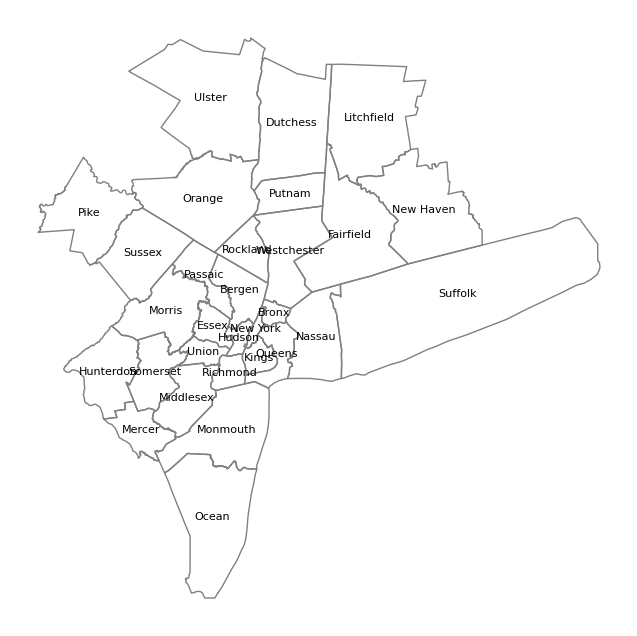

In [17]:
MSA_counties = County[County['GEOID'].isin(nyc_metro_county_fips)]

fig, ax = plt.subplots(figsize=(8,8))

MSA_counties.plot(
    ax=ax,
    edgecolor="gray",
    facecolor="none"
)

# add labels using centroid positions
for idx, row in MSA_counties.iterrows():
    x, y = row.geometry.centroid.coords[0]
    ax.text(
        x, y,
        row["NAME"],
        fontsize=8,
        ha="center",
        va="center"
    )

ax.set_axis_off()
plt.show()

In [6]:
print(len(MSA_counties['GEOID'].unique()))
MSA_counties['GEOID'].unique()

30


array(['34037', '36111', '36103', '34039', '36027', '36059', '34023',
       '36119', '09009', '34017', '36085', '36079', '34025', '34035',
       '34029', '09001', '09005', '34027', '34013', '36081', '34003',
       '36047', '36061', '34031', '36087', '34019', '42103', '36071',
       '36005', '34021'], dtype=object)

In [18]:
# MSA_counties.to_file(root + 'For New Study Area/MSA_counties.shp')

## CBG

In [83]:
CBGs = pd.read_csv('/Users/ryan/Documents/01.Research Projects/18.NYC Congestion Pricing/1.Replica Data Processing/(1226) Four States CBG 2010.csv',
                   dtype={'raw_id':'str'})
# convert WKT string → shapely geometry
CBGs["geom"] = CBGs["geom"].map(wkt.loads)

# build GeoDataFrame
CBGs = gpd.GeoDataFrame(
    CBGs,
    geometry="geom",
    crs="EPSG:4326"
)

In [84]:
CBGs_2020 = pd.read_csv('/Users/ryan/Documents/01.Research Projects/18.NYC Congestion Pricing/1.Replica Data Processing/(1226) Four States CBG 2020.csv',
                   dtype={'raw_id':'str'})
# convert WKT string → shapely geometry
CBGs_2020["geom"] = CBGs_2020["geom"].map(wkt.loads)

# build GeoDataFrame
CBGs_2020 = gpd.GeoDataFrame(
    CBGs_2020,
    geometry="geom",
    crs="EPSG:4326"
)

In [85]:
CBGs = CBGs[CBGs['raw_id'].map(lambda x:x[:5]).isin(MSA_counties['GEOID'].unique())]
CBGs.rename(columns={'raw_id':'GEOID_2010'},inplace=True)
CBGs_2020 = CBGs_2020[CBGs_2020['raw_id'].map(lambda x:x[:5]).isin(MSA_counties['GEOID'].unique())]
CBGs_2020.rename(columns={'raw_id':'GEOID_2020'},inplace=True)

<Axes: >

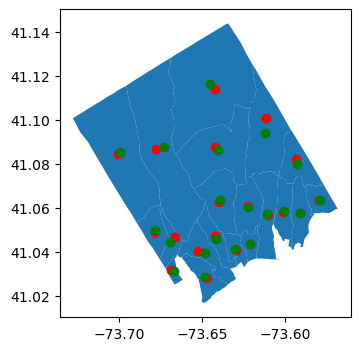

In [87]:
# This is to show that Replica's surface point works better, but not a big difference
CBGs["surface_point"] = shapely.from_wkt(CBGs["surface_point"])
CBGs_pt = gpd.GeoDataFrame(
    CBGs.drop(columns=["geom"]), 
    geometry="surface_point",
    crs="EPSG:4326"
)

CBGs['lng'] = CBGs['geom'].centroid.x
CBGs['lat'] = CBGs['geom'].centroid.y
CBGs_pt_2 = gpd.GeoDataFrame(
    CBGs,
    geometry=gpd.points_from_xy(CBGs["lng"], CBGs["lat"]),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(1,figsize=(4,4))
CBGs.head(20).plot(ax=ax)
CBGs_pt.head(20).plot(ax=ax,color='red')
CBGs_pt_2.head(20).plot(ax=ax,color='green')

In [88]:
CBGs['lng'] = CBGs['surface_point'].map(lambda x: x.x)
CBGs['lat'] = CBGs['surface_point'].map(lambda x: x.y)
CBGs.drop('surface_point',axis=1,inplace=True)

In [90]:
CBGs_2020["surface_point"] = shapely.from_wkt(CBGs_2020["surface_point"])
CBGs_2020['lng'] = CBGs_2020['surface_point'].map(lambda x: x.x)
CBGs_2020['lat'] = CBGs_2020['surface_point'].map(lambda x: x.y)
CBGs_2020.drop('surface_point',axis=1,inplace=True)

In [93]:
CBGs.to_file(root+"For New Study Area/MSA_cbg_2010.geojson", driver="GeoJSON")
CBGs_2020.to_file(root+"For New Study Area/MSA_cbg_2020.geojson", driver="GeoJSON")

<Axes: >

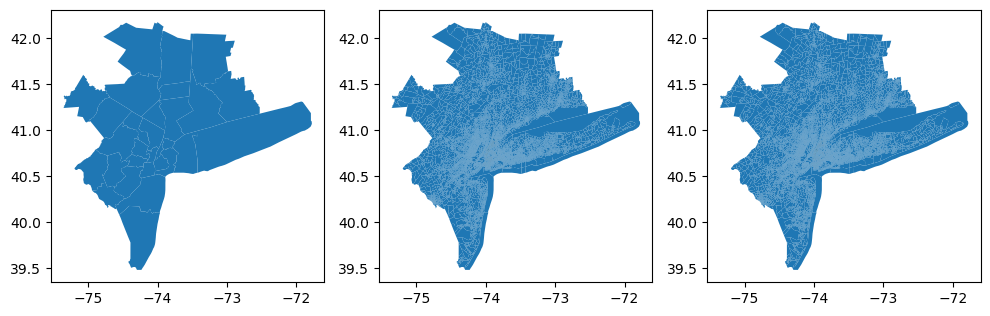

In [94]:
fig, ax = plt.subplots(1,3,figsize=(12,8))
MSA_counties.plot(ax=ax[0])
CBGs.plot(ax=ax[1])
CBGs_2020.plot(ax=ax[2])

In [96]:
CBGs_2020.head()

,GEOID_2020,geom,lng,lat
0,090010101011,"POLYGON ((-73.6959 41.115, -73.69572 41.11471,...",-73.673092,41.087484
1,090010101012,"POLYGON ((-73.70658 41.07953, -73.70644 41.079...",-73.692523,41.069582
2,090010101013,"POLYGON ((-73.72684 41.09942, -73.72682 41.099...",-73.720110,41.099143
3,090010101014,"POLYGON ((-73.69235 41.05714, -73.69148 41.056...",-73.675704,41.048384
4,090010101015,"POLYGON ((-73.7178 41.0912, -73.71777 41.0905,...",-73.699180,41.089762


### Create a cbg matching table

In [116]:
CBGs_2020 = CBGs_2020
CBGs_2010 = CBGs.copy()
projected_crs = "EPSG:2263"
CBGs_2020_proj = CBGs_2020.to_crs(projected_crs)
CBGs_2010_proj = CBGs_2010.to_crs(projected_crs)

# Calculate centroids
CBGs_2020_proj['x'] = CBGs_2020_proj.geometry.centroid.x
CBGs_2020_proj['y'] = CBGs_2020_proj.geometry.centroid.y
CBGs_2010_proj['x'] = CBGs_2010_proj.geometry.centroid.x
CBGs_2010_proj['y'] = CBGs_2010_proj.geometry.centroid.y

# Drop geometry
df_2020 = pd.DataFrame(CBGs_2020_proj.drop(columns=['geometry'], errors='ignore'))
df_2010 = pd.DataFrame(CBGs_2010_proj.drop(columns=['geometry'], errors='ignore'))

coords_2020 = df_2020[['x', 'y']].values
coords_2010 = df_2010[['x', 'y']].values

# === TWO-WAY MATCHING ===

# 1. Match 2020 -> 2010 (each 2020 finds nearest 2010)
tree_2010 = cKDTree(coords_2010)
dist_2020_to_2010, idx_2020_to_2010 = tree_2010.query(coords_2020, k=1)

# 2. Match 2010 -> 2020 (each 2010 finds nearest 2020)
tree_2020 = cKDTree(coords_2020)
dist_2010_to_2020, idx_2010_to_2020 = tree_2020.query(coords_2010, k=1)

# Create match pairs from both directions
matches_2020_to_2010 = set(zip(range(len(df_2020)), idx_2020_to_2010))
matches_2010_to_2020 = set(zip(idx_2010_to_2020, range(len(df_2010))))

# Union of both directions = complete matching
all_matches = matches_2020_to_2010.union(matches_2010_to_2020)

# Build the matching table
rows = []
for idx_2020, idx_2010 in all_matches:
    row = {'GEOID_2020': df_2020.iloc[idx_2020]['GEOID_2020'],
           'GEOID_2010': df_2010.iloc[idx_2010]['GEOID_2010']}
    
    # Add all other 2020 fields with suffix
    for col in df_2020.columns:
        if col != 'GEOID_2020':
            row[f"{col}_2020"] = df_2020.iloc[idx_2020][col]
    
    # Add all other 2010 fields with suffix
    for col in df_2010.columns:
        if col != 'GEOID_2010':
            row[f"{col}_2010"] = df_2010.iloc[idx_2010][col]
    
    # Calculate distance between this pair
    dist = np.sqrt((coords_2020[idx_2020][0] - coords_2010[idx_2010][0])**2 + 
                   (coords_2020[idx_2020][1] - coords_2010[idx_2010][1])**2)
    row['centroid_distance_meters'] = dist
    
    rows.append(row)

matching_table = pd.DataFrame(rows)

# Sort by GEOID_2020
matching_table = matching_table.sort_values('GEOID_2020').reset_index(drop=True)

# Verify completeness
print(f"Unique GEOID_2020 in matching table: {matching_table['GEOID_2020'].nunique()}")
print(f"Unique GEOID_2020 in original: {df_2020['GEOID_2020'].nunique()}")
print(f"Unique GEOID_2010 in matching table: {matching_table['GEOID_2010'].nunique()}")
print(f"Unique GEOID_2010 in original: {df_2010['GEOID_2010'].nunique()}")

# Assertions should pass now
assert matching_table['GEOID_2020'].nunique() == df_2020['GEOID_2020'].nunique()
assert matching_table['GEOID_2010'].nunique() == df_2010['GEOID_2010'].nunique()

Unique GEOID_2020 in matching table: 17443
Unique GEOID_2020 in original: 17443
Unique GEOID_2010 in matching table: 16720
Unique GEOID_2010 in original: 16720


<Axes: >

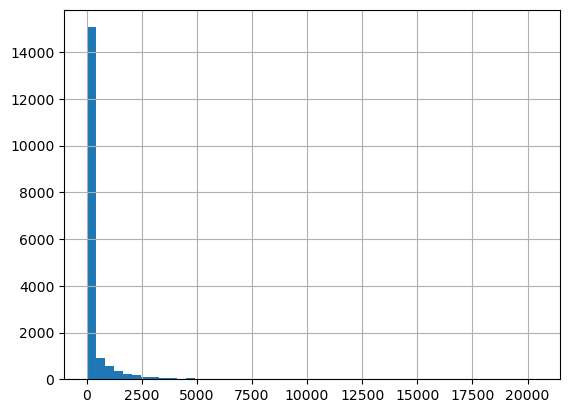

In [122]:
# Do not use matching table unless you really need
matching_table['centroid_distance_meters'].hist(bins=50)

In [124]:
matching_table.to_csv(root+"For New Study Area/cbg_matching_table.csv",index=False)